# 0. Setup Paths

In [1]:
import os

In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [20]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc'),
    'Save_results':os.path.join('Tensorflow','detection_Image')
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

# 8. Load Train Model From Checkpoint

In [5]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [6]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [7]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [8]:
IMAGE_PATH = "C:/Users/panasonic cF SZ6/Downloads/OIP.jpg"

In [9]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

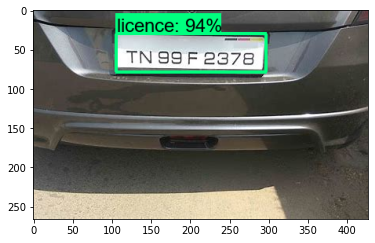

In [10]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# Number Extrect

In [11]:
import easyocr

In [12]:
detection_threshold = 0.7
region_threshold=0.05

In [13]:
def filter_text(region,ocr_result,region_threshold):
  rectangle_size= region.shape[0]* region.shape[1]
  plate =[]
  for result in ocr_result:
    length = np.sum(np.subtract(result[0][1], result[0][0]))
    height = np.sum(np.subtract(result[0][2], result[0][1]))

    if length* height / rectangle_size > region_threshold:
      plate.append(result[1])
  return plate

In [14]:
def ocr_it(image, detections, detection_threshold, region_threshold):

  #scores, boxes and classes above threshold
  scores = list(filter(lambda x: x> detection_threshold,detections['detection_scores']))
  boxes = detections ['detection_boxes'][:len(scores)]
  classes = detections['detection_classes'][:len(scores)]
  
  #full image dimentions
  width= image.shape[1]
  height = image.shape[0]
  
  #Apply roi filtering and ocr
  for idx, box in enumerate(boxes):
    roi= box * [height, width, height, width]
    region = image[int(roi[0]):int(roi[2]), int(roi[1]):int(roi[3])]
    reader = easyocr.Reader(['en'])
    ocr_result = reader.readtext(region)

    text = filter_text(region, ocr_result, region_threshold)

    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
  return text , region

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


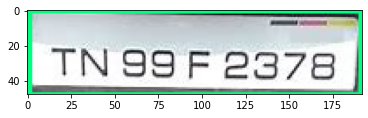

In [16]:
text , region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)

# Store CSV File

In [17]:
import csv
import uuid

In [18]:
def save_results(text, region, csv_filename, folder_path):
  img_name = '{}.jpg'.format(uuid.uuid1())

  cv2.imwrite(os.path.join(folder_path, img_name), region)
  with open(csv_filename, mode='a', newline='') as f:
    csv_writer =csv.writer(f, delimiter=',', quotechar='"', quoting = csv.QUOTE_MINIMAL)
    csv_writer.writerow([img_name, text])

In [23]:
save_results(text, region,os.path.join(  paths['Save_results'] ,'detection_results.csv') , paths['Save_results'])

# 10. Real Time Detections from your Webcam

In [21]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break